## Import libraries

In [25]:
import numpy as np 

import scipy as sp
import scipy.linalg as la   # la.eig()
import scipy.integrate
from scipy.integrate import odeint
from scipy.linalg import eigh  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False   

## Define material properties and element properties

In [27]:
L = 1               # Beam length = 1 m
num_elems = 10      # One-meter beam is divided into ten parts
x = np.linspace(0,L,num_elems+1)   # x.shape =11

l = x[1]-x[0]       # element length            m
E = 210*10**9       # Young's modulus           Pa
u = 0.3             # Poisson's ratio
I = 6.51*10**-8     # Moment of inertia         m^4
Rho = 7860          # Material density          kg/m3
cc = 0.01           # Damping coefficient
q = 10              # Distribution force        N
A =  5*25*10**-4    # Cross-sectional area      m^2



k = (E*I/l**3)*np.array(  [ [ 12,  6*l,    -12,   6*l    ],                     # element Stiffness matrix
                            [ 6*l, 4*l**2, -6*l,  2*l**2 ],
                            [ -12, -6*l,    12,  -6*l    ],
                            [ 6*l, 2*l**2, -6*l,  4*l**2 ] ])

m = (Rho*A*l/420)*np.array([[ 156,    22*l,    54,    -13*l    ],               # element mass matrix
                            [ 22*l,   4*l**2,  13*l,  -3*l**2  ],
                            [ 54,     13*l,    156,   -22*l    ],
                            [ -13*l, -3*l**2, -22*l,   4*l**2  ] ])
c = m*(cc/Rho)                               # element damping matrix 
f = np.array([0.5*q*l,0,0.5*q*l,0])          # element force matrix

## Assemble the overall matrix

In [29]:
def beam_matrx_add(num_elems):
    """
    input:  Number of element
    return: M_end : Overall mass matrix without fixed end constraints
            K_end : Overall stiffness matrix without fixed end constraints
            C_end : Overall damping matrix without fixed end constraints
            F_end : Overall force matrix without fixed end constraints
            F     : Overall force matrix
    """
    M_all = np.zeros((2*num_elems+2,2*num_elems+2))
    K_all = np.zeros((2*num_elems+2,2*num_elems+2))
    C_all = np.zeros((2*num_elems+2,2*num_elems+2))
    F_all = np.zeros(2*num_elems+2)
    
    for i in range(num_elems):
        M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        C_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        F_temp = np.zeros(2*num_elems+2)
        M_temp[2*i:2*i+4, 2*i:2*i+4] = m    
        K_temp[2*i:2*i+4, 2*i:2*i+4] = k    # Slice assignment
        C_temp[2*i:2*i+4, 2*i:2*i+4] = c
        F_temp[2*i:2*i+4] = f
        M_all += M_temp
        K_all += K_temp
        C_all += C_temp
        F_all += F_temp
    M = M_all[2:,2:]    # Remove fixed end degrees of freedom: The first two rows and the first two columns
    K = K_all[2:,2:]
    C = C_all[2:,2:]
    F = F_all[2:]
    return M , K , C, F , F_all
    
M , K , C , F_end , F = beam_matrx_add( num_elems ) # K.shape =(20, 20)
M.shape

(20, 20)

## calculate the eigenvalue and the corresponding eigenvector

In [31]:
omega_2, fai = eigh(K,M)    # Return eigenvalues ​​and eigenvectors
omega = np.sqrt(omega_2)    # omega.shape = 20 # fai.shape = (20, 20)
omega_1 = omega[0]
omega_2 = omega[1]
print(omega)
omega_exact_1=3.515*np.sqrt( E*I/(Rho*A*L**4) )
omega_exact_2=22.04*( E*I/(Rho*A*L**4) )**0.5

error1 = ( abs(omega_exact_1-omega_1)/omega_exact_1)*100
error2 = ( abs(omega_exact_2-omega_2)/omega_exact_2)*100
print('\nexact solution of omega: omega_exact_1= ',omega_exact_1)
print('error of omega1:  ',error1,'%')
print('\nexact solution of omega: omega_exact_2= ',omega_exact_2)
print('error of omega2:  ',error2,'%')

[4.14748655e+01 2.59926926e+02 7.27964128e+02 1.42751510e+03
 2.36348092e+03 3.54076320e+03 4.96786259e+03 6.65556637e+03
 8.60556459e+03 1.06979583e+04 1.42385078e+04 1.72019113e+04
 2.08527161e+04 2.51678370e+04 3.02428656e+04 3.61706999e+04
 4.29290121e+04 5.01175785e+04 5.64379557e+04 7.06314383e+04]

exact solution of omega: omega_exact_1=  41.462853908028
error of omega1:   0.0289694189602956 %

exact solution of omega: omega_exact_2=  259.9833001800675
error of omega2:   0.02168389227229381 %


## Plot: Draw the first three modes

Text(0.5, 1.0, 'Analytical solution in vibration mechanics ')

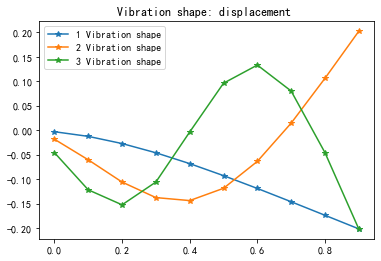

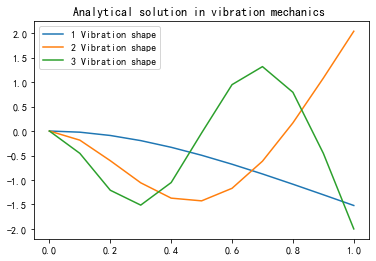

In [33]:
plt.plot(np.arange(0,1,1/num_elems),-fai[::2,0],label="1 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num_elems),-fai[::2,1],label="2 Vibration shape",marker='*')
plt.plot(np.arange(0,1,1/num_elems), fai[::2,2],label="3 Vibration shape",marker='*')  
plt.legend()
plt.title(" Vibration shape: displacement  ")

plt.figure()    ### Exact solutions in vibration mechanics ###
def static(i,x):
    beta_i = (2*i-1)*np.pi / (2*L)
    kexi_i = - ( np.cos(beta_i*L)+np.cosh(beta_i*L) ) / ( np.sin(beta_i*L)+np.sinh(beta_i*L) )
    fai_i = np.cos(beta_i*x) - np.cosh(beta_i*x) + kexi_i*(np.sin(beta_i*x)-np.sinh(beta_i*x))
    return fai_i
for i in range(1,4):
    plt.plot(x,static(i,x),label="{} Vibration shape".format(i))
    plt.legend()
plt.title("Analytical solution in vibration mechanics ")

In [35]:
# plt.plot(np.linspace(0,1,num_elems), fai[1:22:2,0],label="1 Vibration shape",marker='*')
# plt.plot(np.linspace(0,1,num_elems),-fai[1:22:2,1],label="2 Vibration shape",marker='*')
# plt.plot(np.linspace(0,1,num_elems), fai[1:22:2,2],label="3 Vibration shape",marker='*')
# plt.legend()
# plt.title(" Vibration shape: angle ")

## Solve ordinary differential equations

### plot the initial conditions and find The appropriate time series

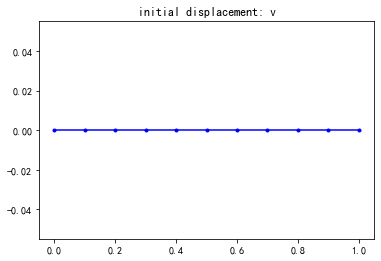

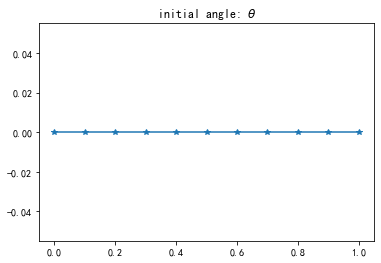

In [37]:
y00 = np.array( [   [0,0,0,0],       # 0 ICs matrix: v1 v1'  theta1 theta1'
                    [0,0,0,0],       # 1
                    [0,0,0,0],       # 2
                    [0,0,0,0],       # 3
                    [0,0,0,0],       # 4 ICs matrix: v4 v4'  theta4 theta4'
                    [0,0,0,0],       # 5
                    [0,0,0,0],       # 6
                    [0,0,0,0],       # 7
                    [0,0,0,0],       # 8
                    [0,0,0,0],       # 9
                    [0,0,0,0] ])     # 10

plt.plot(x,y00[:,0],'-b',marker='.')
plt.title("initial displacement: v")    # plot the initial conditions
plt.figure()
plt.plot(x,y00[:,2],marker='*')
plt.title( r"initial angle: $\theta$ ")

y01 = fai.T @ y00[1:,:].reshape(-1,2) # (20, 2)
y01=y01.reshape(1,-1)   # (1, 40)


t_max = 3*0.15149380807211182          # max time 
dt = (0.15149380807211182/20)*2
t_totality = int( t_max/dt )    # total number of timestep , control stepsize
t = np.linspace(0, t_max, t_totality)       # time series



### Calculate the generalized coordinate solution and the original coordinate solution

In [39]:
result = np.zeros( ( t_totality , len(omega) ) )    #(101,20)

def diff(y,t):                                      # define ODE 
    F_i = fai[: ,i].T  @ F_end * x[ int(i/2) ]/L * np.sin(1.1*omega_1*t)  
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i     

T_0=0
w_0=1000000
for i in range( len(omega) ):               # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i]

    if  2*np.pi*np.sqrt(M_i/K_i) > T_0:
        T_0 = 2*np.pi*np.sqrt(M_i/K_i)      # Try to find the best time step
    if np.sqrt(K_i/M_i) < w_0:
        w_0 = np.sqrt(K_i/M_i)

    y0 = [ y01[0,(2*i)],y01[0,(2*i+1)] ]    # initial conditions
    sol = odeint(diff, y0, t)               # Call the odeint function to solve
    result[:,i] += sol[:,0]                 # Put the result of each solution into the  "result" matrix
print("result.shape  =",result.shape) # =(101,20)=(t_totality,len(omega))

print("\nMaximum   period :    T_0 =",T_0,'\nMaximum angular speed:w_0 = ',w_0)



 # # # # # # # # Superimpose to get the response of the original coordinates # # # # # # 
x_result = np.zeros((len(omega),t_totality))   #  result of original coordinates
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 
print("\nx_result.shape=",x_result.shape) # =(20, 101)=( len(omega),t_totality )


result.shape  = (30, 20)

Maximum   period :    T_0 = 0.15149380807211182 
Maximum angular speed:w_0 =  41.47486545581294

x_result.shape= (20, 30)


Text(0.5, 0.92, 'angle $\\theta$ change ')

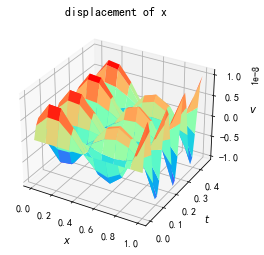

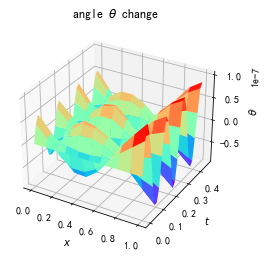

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[::2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')


fig1 = plt.figure()
ax1 = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax1.plot_surface(X,T,x_result[1:2*num_elems:2,::].T,cmap='rainbow')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$t$')
ax1.set_zlabel(r'$\theta $')
ax1.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

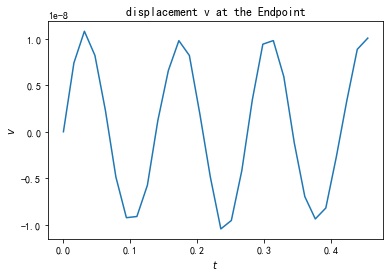

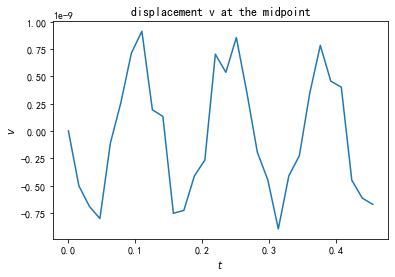

In [43]:
plt.plot( t,x_result[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

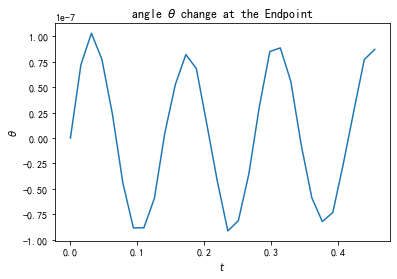

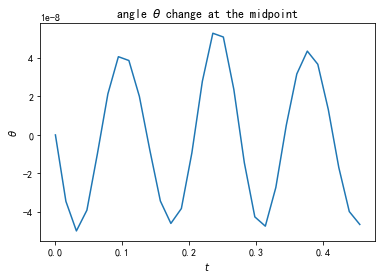

In [45]:
plt.plot( t,x_result[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')

plt.figure()
plt.plot( t,x_result[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')

# Only endpoint force

In [47]:
result_1 = np.zeros(    ( t_totality,len(omega)  )     )
                    #   1    2    3    4    5    6    7    8    9    10
F_endpoint = np.array([0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 10,0])

def diff(y,t):                                      # define ODE 
    yt, theta = y
    F_i = (fai[:,i].T) @ F_endpoint * np.sin( 1.1*omega_1*t )
    return theta , (F_i-K_i*yt-C_i*theta) / M_i     

y10 = np.array( [0,0,0,0,       # 0  ICs matrix: ……
                 0,0,0,0,       # 1     
                 0,0,0,0,       # 2
                 0,0,0,0,       # 3
                 0,0,0,0,       # 4  v4 v4'  theta4 theta4'
                 0,0,0,0,       # 5
                 0,0,0,0,       # 6
                 0,0,0,0,       # 7
                 0,0,0,0,       # 8
                 0,0,0,0,       # 9
                 0,0,0,0 ] )    # 10

for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    

    y10_0 = [ y10[4+2*i],y10[4+2*i+1] ]     # initial conditions                      
    sol_1 = odeint(diff, y10_0, t)          # Call the odeint function to solve
    result_1[:,i] += sol_1[:,0]             # Put the result of each solution into the  "result" matrix
print("result of Generalized Coordinates : result.shape   =",result_1.shape) # =(101,20)

x_result_1 = np.zeros((len(omega),t_totality))   #(20,101) #  result of original coordinates
for i in range(len(omega)):
    x_result_1 += fai[:,i].reshape(-1,1) @ result_1[:,i].reshape(1,-1) 
print("result  of  original  coordinates : x_result.shape =",x_result_1.shape) # =(20, 101)


result of Generalized Coordinates : result.shape   = (30, 20)
result  of  original  coordinates : x_result.shape = (20, 30)


Text(0.5, 0.92, 'angle $\\theta$ change ')

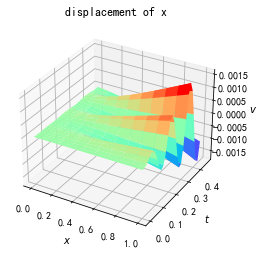

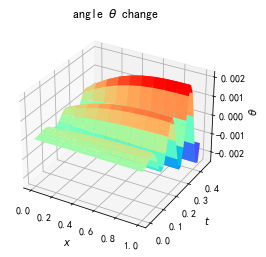

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result_1[::2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result_1[1:2*num_elems:2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel(r'$\theta $')
ax.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

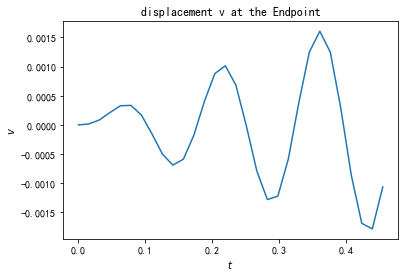

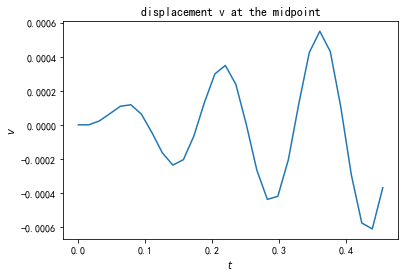

In [51]:
plt.figure()
plt.plot( t,x_result_1[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result_1[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

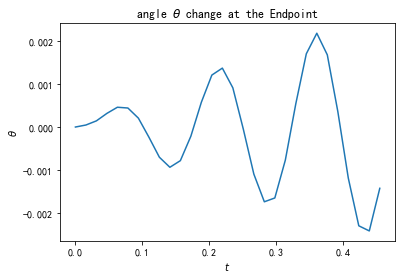

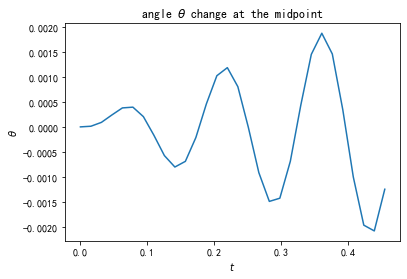

In [53]:
plt.figure()
plt.plot( t,x_result_1[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')
plt.figure()
plt.plot( t,x_result_1[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')

# free vibration

D:\aMyCodeGroup\Anaconda\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
result of Generalized Coordinates : result.shape = (30, 20)
result of original coordinates: x_result.shape =  (20, 30)


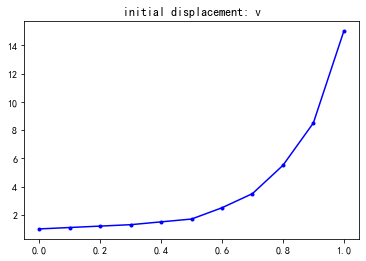

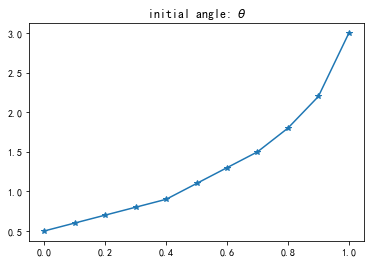

In [54]:
result_2 = np.zeros(    ( t_totality,len(omega)  )     )

y20 = np.array( [   [1,0,0.5,0],         # 0 ICs matrix: u1 u1'  theta1 theta1'……
                    [1.1,0,0.6,0],       # 1
                    [1.2,0,0.7,0],       # 2
                    [1.3,0,0.8,0],       # 3
                    [1.5,0,0.9,0],       # 4
                    [1.7,0,1.1,0],       # 5
                    [2.5,0,1.3,0],       # 6
                    [3.5,0,1.5,0],       # 7
                    [5.5,0,1.8,0],       # 8
                    [8.5,0,2.2,0],       # 9
                    [15,0,3,0]   ] )     # 10

plt.plot(x,y20[:,0],'-b',marker='.')
plt.title("initial displacement: v")
plt.figure()
plt.plot(x,y20[:,2],marker='*')
plt.title(r"initial angle: $\theta$ ")

y21 = fai.T @ y20[1:,:].reshape(-1,2) # (20, 2)
y21=y21.reshape(1,-1)   # (1, 40)

def diff(y,t):                                      # define ODE 
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i

for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    F_i = (fai[:,i].T) @ F_endpoint 
    
    y20_0 = [ y21[0,(2*i)],y21[0,(2*i+1)] ]                          # initial conditions
    
    sol_2 = odeint(diff, y20_0, t)           # Call the odeint function to solve
    result_2[:,i] += sol_2[:,0]             # Put the result of each solution into the  "result" matrix
    

print("result of Generalized Coordinates : result.shape =",result_2.shape) # =(101,20)


x_result_2 = np.zeros((len(omega),t_totality))   # (20,101) #  result of original coordinates
for i in range(len(omega)):
    x_result_2 += fai[:,i].reshape(-1,1) @ result_2[:,i].reshape(1,-1) 

print("result of original coordinates: x_result.shape = ",x_result_2.shape) # =(20, 101)


Text(0.5, 0.92, 'angle $\\theta$ change ')

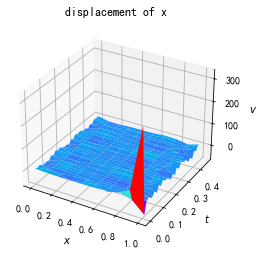

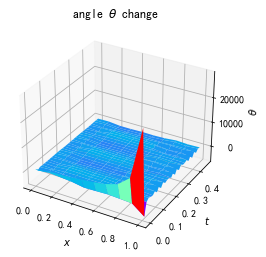

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result_2[::2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result_2[1:2*num_elems:2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel(r'$\theta $')
ax.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

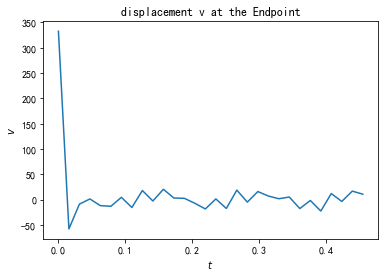

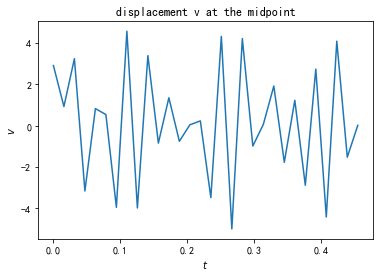

In [56]:
plt.figure()
plt.plot( t,x_result_2[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result_2[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

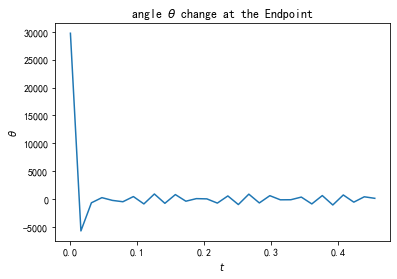

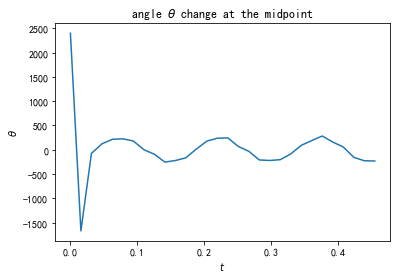

In [57]:
plt.figure()
plt.plot( t,x_result_2[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')
plt.figure()
plt.plot( t,x_result_2[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')